In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import pingouin as pg
import scipy.stats as ss
from scipy.stats import chi2_contingency


#plt.figure(figsize = (17,8))

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Первичный анализ данных

In [2]:
reg_data=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-tihonova/shared/problem1-reg_data.csv', sep=';')

In [3]:
reg_data.head(5) #данные о времени регистрации

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [5]:
auth_data=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-tihonova/shared/problem1-auth_data.csv', sep=';')

In [6]:
auth_data.head(5) #данные о времени захода пользователей в игру

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [7]:
auth_data.shape 

(9601013, 2)

In [8]:
reg_data.shape

(1000000, 2)

In [9]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [10]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [10]:
#Видим, что тип данных int64, следовательно, в функции нужно учесть перевод во временной тип данные о времени

In [12]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.normalize()
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.normalize()

In [13]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


In [14]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   auth_ts  datetime64[ns]
 1   uid      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


In [16]:
reg_data.isnull().any()

reg_ts    False
uid       False
dtype: bool

In [17]:
auth_data.isnull().any()

auth_ts    False
uid        False
dtype: bool

In [14]:
#убедились в типе данных и проверили наличие нулевых значений - в дф нулевых значений нет

In [18]:
reg_data.duplicated().any()

False

In [19]:
auth_data.duplicated().any()

False

In [ ]:
#проверили наличие дубликатов - нет

In [20]:
first_day = reg_data['reg_ts'].max()
last_dae = reg_data['reg_ts'].min()

In [21]:
first_day

Timestamp('2020-09-23 00:00:00')

In [22]:
last_dae

Timestamp('1998-11-18 00:00:00')

# ВЫВОД:
1. Размер reg_data (1000000, 2), пустых значений нет, дубликатов нет
2. Размер auth_data (9601013, 2), пустых значений нет, дубликатов нет
3. Тип  данных int64, в функции нужно учесть перевод во временной тип данные о времени
4. Посмотрели диапазон дат, на основании этого сможем выбрать период для расчета Retention

# Задание 1
Retention – один из самых важных показателей в компании. 
Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).


In [2]:
reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')
auth = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';') 
#взяли новые переменные, чтобы для "исходных" данных писать функцию

In [3]:
def retention(reg, auth, first_date, last_date):
    
    #переводим в нужный тип
    reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit='s').dt.normalize()
    auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], unit='s').dt.normalize()
    
    #объеденяем данные
    full_df = pd.merge(reg, auth, on='uid')
    
    #определяю границы дат
    first_date = pd.to_datetime(first_date)
    last_date = pd.to_datetime(last_date)
    
    #берем корректные даты периода
    full_df = full_df[(full_df['reg_ts'] >= first_date) & (full_df['auth_ts'] <= last_date)]

    
    #считаем разницу в днях между через сколько произошла авторизация после регистрации
    full_df['days_retention'] = (full_df['auth_ts'] - full_df['reg_ts']).dt.days
    
    #расчет retention 
    cohort = full_df.groupby(['reg_ts', 'days_retention']).agg(users=('uid', 'nunique')).reset_index()
    cohort['total_users'] = cohort.groupby('reg_ts')['users'].transform('first')
    cohort['retention'] = cohort['users'] / cohort['total_users']
    
    #создание сводной таблицы
    cohort_pivot = cohort.pivot_table(index='reg_ts', columns='days_retention', values='retention')
    
    #убираем нулевой период
    cohort_pivot = cohort_pivot.drop(0, axis=1)
    
    #Блок визуализации
    cohort_pivot.index = cohort_pivot.index.date
    
    # Устанавливаем размер графика
    plt.figure(figsize=(12, 8)) 
    
    ax = sns.heatmap(data = cohort_pivot, 
                     cmap = 'YlOrRd', 
                     annot = True, 
                     fmt = '.0%', 
                     cbar = True, 
                     linewidths = 0.5, 
                     square = True)
    ax.set_title('Retention', fontsize = 15)
    ax.set_ylabel('Дата регистрации')
    ax.set_xlabel('Дней после регистрации')
    return cohort_pivot


In [ ]:
#рассчет Retention за сентябрь (с 1-23 сентября 2023 года) можно вставить любой инетресующий период

days_retention,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
2020-09-01,0.020177,0.040984,0.042245,0.046028,0.064313,0.056116,0.064313,0.040984,0.054224,0.051072,...,0.054855,0.042875,0.044136,0.043506,0.050441,0.041614,0.043506,0.035939,0.043506,0.015763
2020-09-02,0.025189,0.039043,0.046599,0.056675,0.062343,0.071159,0.062972,0.048489,0.040932,0.056675,...,0.043451,0.049748,0.052897,0.041562,0.048489,0.039043,0.037154,0.046599,0.026448,NaN
2020-09-03,0.023256,0.054054,0.047140,0.065368,0.069767,0.085481,0.063482,0.054683,0.062854,0.063482,...,0.059711,0.054683,0.053426,0.043997,0.048397,0.046512,0.054683,0.023884,NaN,NaN
2020-09-04,0.020088,0.036409,0.036409,0.051475,0.064030,0.072819,0.049592,0.053358,0.043315,0.056497,...,0.055869,0.043942,0.045198,0.045198,0.042687,0.047709,0.026365,NaN,NaN,NaN
2020-09-05,0.027569,0.039474,0.046366,0.054511,0.058897,0.074561,0.048872,0.050752,0.054511,0.060150,...,0.053885,0.045113,0.051378,0.044486,0.047619,0.025063,NaN,NaN,NaN,NaN
2020-09-06,0.031270,0.043152,0.054409,0.056285,0.058787,0.068168,0.060663,0.058161,0.055034,0.048780,...,0.051907,0.055034,0.045654,0.048155,0.025641,NaN,NaN,NaN,NaN,NaN
2020-09-07,0.029357,0.042473,0.053716,0.050593,0.063710,0.073079,0.052467,0.041224,0.056215,0.059963,...,0.050593,0.042473,0.050593,0.033729,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08,0.017456,0.039277,0.039277,0.048628,0.076060,0.075436,0.066085,0.051746,0.051746,0.065461,...,0.051746,0.047382,0.030549,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,0.017424,0.032358,0.046671,0.057250,0.066584,0.057250,0.059116,0.043559,0.050404,0.037337,...,0.048538,0.024269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-10,0.020510,0.042884,0.047856,0.042262,0.067744,0.062772,0.070851,0.048477,0.045370,0.056557,...,0.036047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


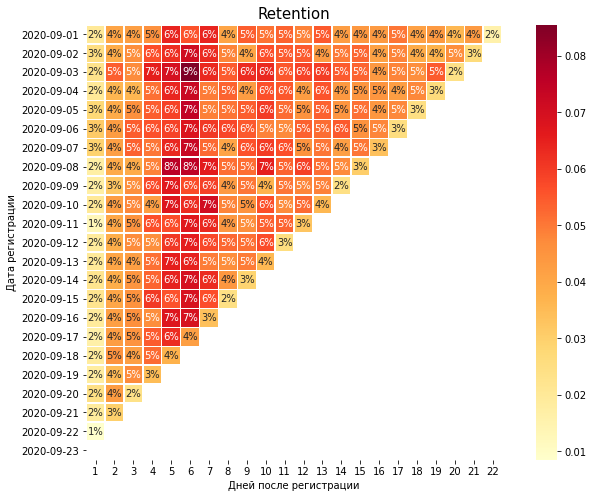

In [4]:
retention(reg, auth,'2020-09-01', '2020-09-23' ) 

# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

# Первичный анализ данных

In [4]:
data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-tihonova/FINAL/Проект_1_Задание_2.csv', sep = ';')

In [14]:
data.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [16]:
data.shape

(404770, 3)

In [17]:
data.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [20]:
data.isnull().any()

user_id      False
revenue      False
testgroup    False
dtype: bool

In [21]:
data.duplicated().any()

False

# Выводы
Размер дф (404770, 3), пустых значений нет, дубликатов нет

In [46]:
data.groupby('testgroup').describe()

user_id                                                         \
              count           mean            std  min       25%       50%   
testgroup                                                                    
a          202103.0  202555.909843  116802.329266  2.0  101502.5  202988.0   
b          202667.0  202215.564389  116891.926690  1.0  100855.5  201821.0   

                                revenue                                        \
                75%       max     count       mean         std  min  25%  50%   
testgroup                                                                       
a          303559.0  404769.0  202103.0  25.413720  920.768137  0.0  0.0  0.0   
b          303602.5  404770.0  202667.0  26.751287  287.324162  0.0  0.0  0.0   

                         
           75%      max  
testgroup                
a          0.0  37433.0  
b          0.0   4000.0

In [22]:
#Выводим отдельно тестовую и контрольную гурппу 

In [38]:
control_group = data.query('testgroup == "a"')


In [39]:
test_group = data.query('testgroup == "b"') 

In [35]:
control_group.head(5)

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a


In [36]:
control_group.shape

(202103, 3)

In [41]:
test_group.head(5)

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b


In [43]:
test_group.shape

(202667, 3)

In [44]:
#202103+202667 = 404770 - ничего не потеряли

In [ ]:
#посмотрим  распределения revenue для каждой группы

In [65]:
control_group_rev = data.query('testgroup == "a" and revenue > 0')
test_group_rev = data.query('testgroup == "b" and revenue > 0')

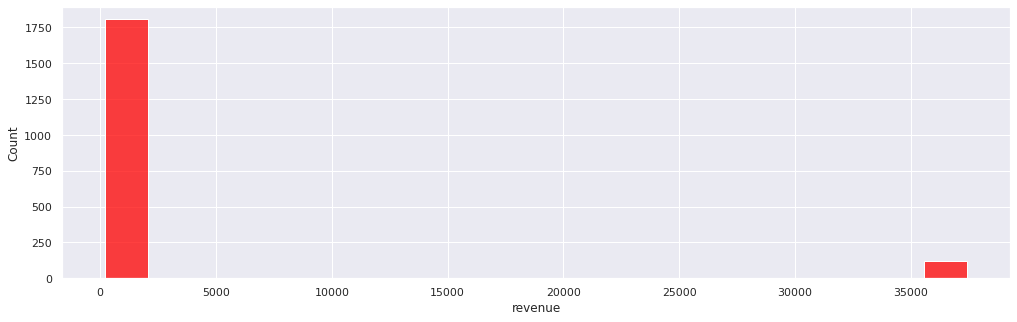

In [66]:
sns.set(rc={'figure.figsize': (17, 5)})
sns.set(font_scale=1)
sns.histplot(data=control_group_rev, x='revenue', color='red', bins=20) 

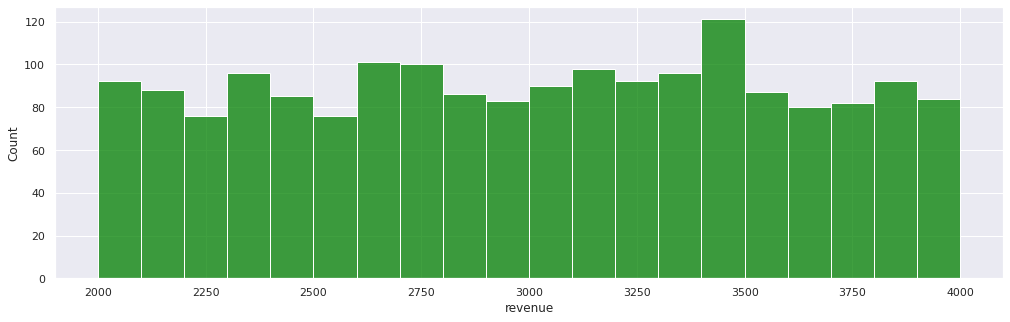

In [67]:
sns.set(rc={'figure.figsize': (17, 5)})
sns.set(font_scale=1)
sns.histplot(data=test_group_rev, x='revenue', color='green', bins=20) 

In [72]:
data.groupby('testgroup').agg({'revenue':'sum'})

,revenue
testgroup,
a,5136189
b,5421603


# интепритация графиков:
В контрольной группе  много кто платит маленькую сумму, но есть выброс, где маленькео кол-во платит большую сумму. В тестовой группе нет расбросов, но и нет очень больших сумм, как в 1 группе

In [15]:
# Расчет метрик для каждой группы
df_analysis = data.groupby('testgroup', as_index=False)\
    .agg( all_users=('user_id', 'count'), total_revenue=('revenue', 'sum')) # Общее количество пользователей, Общий доход

# Подсчет количества платящих пользователей
pay_users = data[data['revenue'] > 0].groupby('testgroup')['user_id'].count().reset_index()
pay_users.columns = ['testgroup', 'users_pay']  # Переименуем колонки

# Объединяем результаты
df_analysis = df_analysis.merge(pay_users, on='testgroup', how='left')

# Расчет ARPU и ARPPU
df_analysis['ARPU'] = df_analysis['total_revenue'] / df_analysis['all_users']
df_analysis['ARPPU'] = df_analysis['total_revenue'] / df_analysis['users_pay'] 

# Процент платящих пользователей от общего числа пользователей
df_analysis['CR'] = (df_analysis['users_pay'] / df_analysis['all_users']) * 100  

In [16]:
df_analysis

,testgroup,all_users,total_revenue,users_pay,ARPU,ARPPU,CR
0,a,202103,5136189,1928,25.413720,2663.998444,0.953969
1,b,202667,5421603,1805,26.751287,3003.658172,0.890624


In [ ]:
#Сформулируем гипотезы для t-теста (МЕТРИКА ARPU)
#H0: ARPU в группе "а" и группе "в" не отличается
#H1: ARPU в группе "а" и группе "в"  отличается

In [5]:
# контрольная группа (a)
control = data.loc[data.testgroup == 'a']

In [6]:
# тестовая группа (b)
test = data.loc[data.testgroup == 'b']

In [7]:
ss.ttest_ind(control.revenue, test.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

In [ ]:
#Вывод : pvalue > 0.05, поэтому нулевую гипотезу отклонить нельзя.

In [ ]:
#Сформулируем гипотезы для t-теста (МЕТРИКА ARPPU)
#H0: ARPPU в группе "а" и группе "в" не отличается
#H1: ARPPU в группе "а" и группе "в"  отличается

In [11]:
# контрольная группа (a)
control_2 = data.loc[(data.testgroup == 'a') & (data.revenue > 0)]

In [12]:
# тестовая группа
test_2 = data.loc[(data.testgroup == 'b') & (data.revenue > 0)]

In [13]:
ss.ttest_ind(control_2.revenue, test_2.revenue)

Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)

In [ ]:
#Вывод : pvalue > 0.05, поэтому нулевую гипотезу отклонить нельзя.

In [ ]:
#Сформулируем гипотезы  
#H0: CR в контрольной и тестовой группах не отличается
#H1: CR в контрольной и тестовой группах отличается

In [19]:
# добавляем информацию оплаты пользователя
df_ab = data.assign(yes_no = np.where(data.revenue == 0, 'No', 'Yes'))
df_ab.head()

,user_id,revenue,testgroup,yes_no
0,1,0,b,No
1,2,0,a,No
2,3,0,a,No
3,4,0,b,No
4,5,0,b,No


In [20]:
table = pd.crosstab(df_ab.testgroup, df_ab.yes_no)

In [21]:
table

yes_no,No,Yes
testgroup,,
a,200175,1928
b,200862,1805


In [22]:
chi2_contingency(table)[1]

0.03647561892312613

In [23]:
#Вывод : pvalue < 0.05, поэтому нулевую гипотезу отклонить можно.
#Различие CR в контрольной и тестовой группах статистически значимо

# Вывод:
В ходе анализа метрик ARPU и ARPPU в тестовой и контрольной группах, можно сделать вывод что они не являются статистически значимыми. Статистически значимое различие есть только по метрике CR. На основании представленных данных можно сделать вывод, что набор предложений в контрольной группе оказался более эффективным.

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

# Вывод
Для оценки результатов прошедшего события в игре можно использовать следующие метрики:
1. Количество игроков, принявших участие в событии:

-Общее количество участников.

-Количество новых игроков, впервые принявших участие в событии.

-DAU - количество уникальных активных пользователей, которые заходили в игру ежедневно.

2. Уровень вовлеченности игроков:

-Количество пройденных уровней в среднем на одного игрока.

-Процент игроков, успешно завершивших все уровни события.

-Количество попыток, потребовавшихся игрокам для прохождения всех уровней.

-Среднее время прохождения каждого уровня.

3. Retention пользователей после получения бонусов. Сможем оценить, насколько бонусы игры интересны пользователям.

4. Денежные метрики (ARPU, ARPPU), если события предпологают какие-либо покупки в игре


Если в другом событии механика будет усложнена, где при неудачных попытках игроки будут откатываться на несколько уровней назад, то к текущим метрикам нужно добавить следующие метрики:

1. Churn Rate - количество пользователей, которые отказались после определенного события.)
2. Количество игроков переставших играть после отката: отражает уровень удовлетворенности игроков и их готовность продолжать участие в событии.
3. Количесвто игроков, оставшихся в игре после отката.

как вывод посмотреть сколько игроков долшло до финиша после откатов и без откатов.